In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
ls

128/       models/       salt.csv         test/                train/
losses.py  __pycache__/  Setup TGS.ipynb  TGS_fastai_v1.ipynb  train.csv


In [3]:
from fastai import *
from fastai.vision import *
from pathlib import Path

In [4]:
show_install(1)



```text
=== Software === 
python version  : 3.6.6
fastai version  : 1.0.6.dev0
torch version   : 1.0.0.dev20181015
nvidia driver   : 396.54
torch cuda ver  : 9.2.148
torch cuda is   : available
torch cudnn ver : 7104
torch cudnn is  : enabled

=== Hardware === 
nvidia gpus     : 1
torch available : 1
  - gpu0        : 8119MB | Quadro P4000

=== Environment === 
platform        : Linux-4.4.0-130-generic-x86_64-with-debian-stretch-sid
distro          : Ubuntu 16.04 Xenial Xerus
conda env       : fastai
python          : /home/paperspace/anaconda3/envs/fastai/bin/python
sys.path        : 
/home/paperspace/anaconda3/envs/fastai/lib/python36.zip
/home/paperspace/anaconda3/envs/fastai/lib/python3.6
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/lib-dynload
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages
/home/paperspace/fastai
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/IPython/extensions
/home/paperspace/.ipython

Wed Oct 17 08:26:28 2018   

In [5]:
MASKS_FN = 'train.csv'
TRAIN_DN = Path('train/images/')
MASKS_DN = Path('train/masks/')
TEST = Path('test/images/')
PATH = Path('')
PATH128 = Path('128/')
TMP = Path('/tmp')
MODEL = Path('/model')

PATH128.mkdir(exist_ok=True)
(PATH128/'train').mkdir(exist_ok=True)
(PATH128/'test').mkdir(exist_ok=True)
(PATH128/MASKS_DN).mkdir(exist_ok=True)
(PATH128/TRAIN_DN).mkdir(exist_ok=True)
(PATH128/TEST).mkdir(exist_ok=True)

seg = pd.read_csv(PATH/MASKS_FN).set_index('id')

sz = 101
bs = 64
nw = 4

In [6]:
train_names_png = [TRAIN_DN/f for f in os.listdir(PATH/TRAIN_DN)]
train_names = list(seg.index.values)
masks_names_png = [MASKS_DN/f for f in os.listdir(PATH/MASKS_DN)]
test_names_png = [TEST/f for f in os.listdir(PATH/TEST)]

In [7]:
train_names_png[0], masks_names_png[0], test_names_png[0]

(PosixPath('train/images/06289f69f8.png'),
 PosixPath('train/masks/06289f69f8.png'),
 PosixPath('test/images/3df20bcdfb.png'))

In [8]:
seg['isSalt'] = seg['rle_mask'].apply(lambda x : type(x)!=float).astype(int)

In [9]:
salt = seg['isSalt']
salt.to_csv(PATH/'salt.csv')

In [10]:
x_names = [f'{x}.png' for x in train_names if(type(seg.loc[x]['rle_mask'])!=float)]
x_names_path = np.array([TRAIN_DN/x for x in x_names])

In [11]:
x_names_path[0:5]

array([PosixPath('train/images/a266a2a9df.png'),
       PosixPath('train/images/75efad62c1.png'),
       PosixPath('train/images/34e51dba6a.png'),
       PosixPath('train/images/4875705fb0.png'),
       PosixPath('train/images/782ae9b7e7.png')], dtype=object)

## Model

In [12]:
tfms = get_transforms(do_flip=True, max_rotate=10, max_zoom=1.2, max_lighting=0.3, max_warp=0.15)
md = ImageDataBunch.from_csv(path = PATH, folder=PATH/TRAIN_DN, size=101,
                         ds_tfms = tfms, 
                        suffix= '.png', csv_labels='salt.csv')

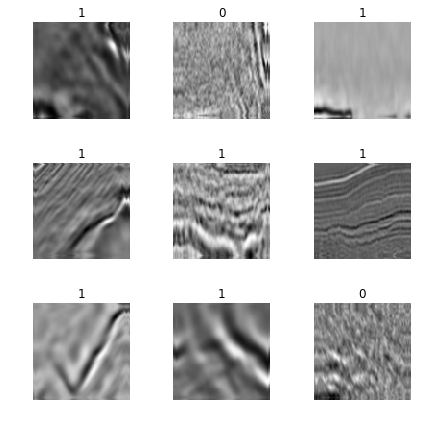

In [13]:
md.show_batch(rows=3, figsize=(6,6))

In [14]:
x,y = next(iter(md.train_dl))

In [15]:
x.shape, y.shape, x.dtype, y.dtype

(torch.Size([64, 3, 101, 101]), torch.Size([64]), torch.float32, torch.int64)

In [16]:
resnet = tvm.resnet34

In [17]:
learn = ConvLearner(md, resnet, metrics=accuracy)

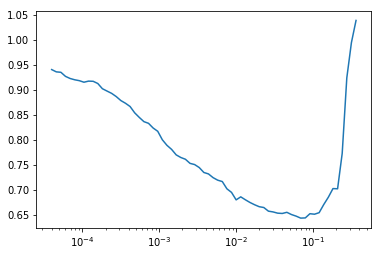

In [18]:
lr_find(learn)
learn.recorder.plot()

In [19]:
learn.fit_one_cycle(4, 3e-3, wd=0.4, div_factor=10, pct_start=0.5)

Total time: 00:21
epoch  train loss  valid loss  accuracy
0      0.575640    0.561291    0.761421  (00:05)
1      0.437584    0.291404    0.879442  (00:05)
2      0.368625    0.267573    0.887056  (00:05)
3      0.330505    0.269558    0.884518  (00:05)



In [22]:
learn.save('0')

In [96]:
ls models

0.pth  tmp.pth


In [23]:
learn.load('0')

In [24]:
learn.unfreeze()

In [25]:
lr=1e-4
learn.fit_one_cycle(4, slice(lr/25,lr), pct_start=0.05)

Total time: 00:28
epoch  train loss  valid loss  accuracy
0      0.269849    0.259773    0.883971  (00:07)
1      0.263886    0.241852    0.891148  (00:07)
2      0.248120    0.244334    0.895933  (00:06)
3      0.245644    0.236766    0.895933  (00:07)



# UNET

## Model

In [8]:
def get_datasets(path, val_idxs):
#   val_idxs = range(400)
#   path = PATH128
  x_fns = [path/f for f in train_names_png]
  y_fns = [path/f for f in masks_names_png]
  mask = [o  not in val_idxs for o in range(len(x_fns))]
  arrs = arrays_split(mask, x_fns, y_fns)
  return [SegmentationDataset(*o) for o in arrs]

In [9]:
train_ds,valid_ds = get_datasets(PATH128, range(400))

In [10]:
train_ds, valid_ds

(SegmentationDataset of len 3600, SegmentationDataset of len 400)

In [13]:
test_ds = SegmentationDataset(test_names_png,test_names_png)

In [16]:
x,y = next(iter(train_ds))
x.shape, y.shape, type(x), type(y)

(torch.Size([3, 128, 128]),
 torch.Size([1, 128, 128]),
 fastai.vision.image.Image,
 fastai.vision.image.ImageMask)

In [17]:
def get_tfm_datasets(path, val_idxs, size):
    datasets = get_datasets(path, val_idxs)
    tfms = get_transforms(do_flip=True, max_rotate=4, max_lighting=0.2, max_warp=0.15)
    return transform_datasets(train_ds, valid_ds, test_ds=test_ds, tfms=tfms, tfm_y=True, size=size, padding_mode='border')
  
train_tds, _, _= get_tfm_datasets(PATH128, range(400), 128)

In [18]:
def get_data(val_idxs, sz, bs):
    return DataBunch.create(*get_tfm_datasets(PATH128, val_idxs, sz), bs=bs)

In [63]:
data = get_data(range(400), 128, bs=64)

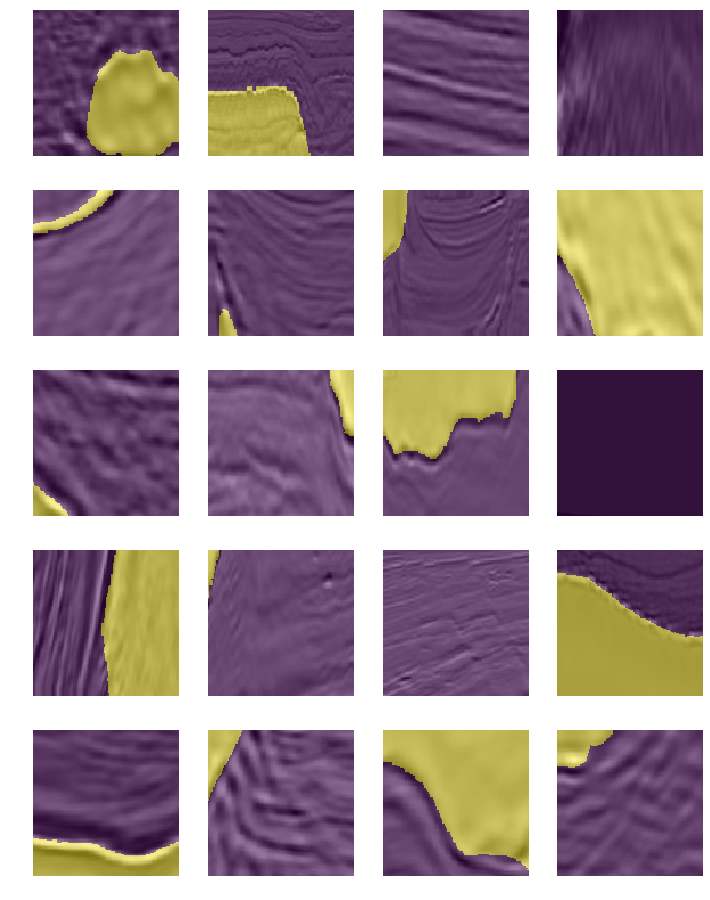

In [64]:
_,axes = plt.subplots(5,4, figsize=(12,16))
for i, ax in enumerate(axes.flat):
    imgx,imgy = train_tds[i]
    imgx.show(ax, y=imgy)

In [65]:
def iou(input:Tensor, targs:Tensor) -> Rank0Tensor:
    "IoU coefficient metric for binary target."
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    targs = targs.view(n,-1)
    intersect = (input*targs).sum().float()
    union = (input+targs).sum().float()
    return intersect / (union-intersect+1.0)

In [66]:
metrics=[accuracy, iou]

In [67]:
def load_pretrained(model, path):
    weights = torch.load(path, map_location=lambda storage, loc: storage)
    model.load_state_dict(weights, strict=False)     
    return model

In [68]:
from fastai.vision.models.unet import *
body = create_body(tvm.resnet34(True), -2) #/root/.torch/models/
body = load_pretrained(body, 'models/0.pth')

In [69]:
model = DynamicUnet(body, n_classes=2).cuda()

learn = Learner(data, model, metrics=metrics,
                loss_fn=CrossEntropyFlat())

In [70]:
learn.split([model[0][6], model[1]])
learn.freeze()

In [71]:
learn.load('/home/paperspace/AI/TGS/models/unet')

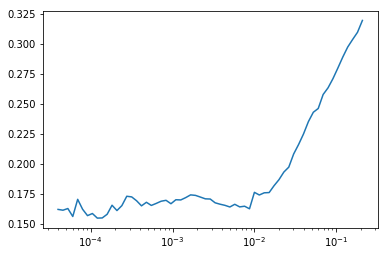

In [62]:
lr_find(learn)
learn.recorder.plot()

In [72]:
learn.fit_one_cycle(16, 1e-2, wd=0.4, div_factor=10, pct_start=0.5)

Total time: 04:13
epoch  train loss  valid loss  accuracy  iou     
0      0.146109    0.152179    0.944565  0.770676  (00:16)
1      0.155201    0.314375    0.878244  0.642859  (00:15)
2      0.163934    0.176167    0.938624  0.757816  (00:15)
3      0.179118    0.282445    0.931219  0.718912  (00:16)
4      0.185759    0.214464    0.927054  0.706844  (00:15)
5      0.206304    0.361082    0.894477  0.553808  (00:16)
6      0.207594    0.269304    0.896589  0.633426  (00:16)
7      0.222782    0.254013    0.907854  0.650219  (00:16)
8      0.229958    0.436372    0.838114  0.302339  (00:15)
9      0.227325    0.370224    0.843842  0.334280  (00:15)
10     0.224774    0.209621    0.921131  0.694261  (00:15)
11     0.216476    0.272872    0.877301  0.473831  (00:15)
12     0.192115    0.243804    0.901479  0.682691  (00:15)
13     0.174973    0.136439    0.947112  0.786359  (00:15)
14     0.156646    0.139319    0.947232  0.792822  (00:15)
15     0.147441    0.134710    0.948427  0.7947

In [103]:
learn.save('unet')

In [50]:
out = learn.get_preds()

In [73]:
show_install(1)



```text
=== Software === 
python version  : 3.6.6
fastai version  : 1.0.6.dev0
torch version   : 1.0.0.dev20181015
nvidia driver   : 396.54
torch cuda ver  : 9.2.148
torch cuda is   : available
torch cudnn ver : 7104
torch cudnn is  : enabled

=== Hardware === 
nvidia gpus     : 1
torch available : 1
  - gpu0        : 8119MB | Quadro P4000

=== Environment === 
platform        : Linux-4.4.0-130-generic-x86_64-with-debian-stretch-sid
distro          : Ubuntu 16.04 Xenial Xerus
conda env       : fastai
python          : /home/paperspace/anaconda3/envs/fastai/bin/python
sys.path        : 
/home/paperspace/anaconda3/envs/fastai/lib/python36.zip
/home/paperspace/anaconda3/envs/fastai/lib/python3.6
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/lib-dynload
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages
/home/paperspace/fastai
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/IPython/extensions
/home/paperspace/.ipython

Wed Oct 17 09:59:49 2018   

In [52]:
preds, targ = out

In [53]:
iou(preds, targ)

torch.Size([400, 2, 128, 128])
torch.Size([400, 1, 128, 128])
400


RuntimeError: The size of tensor a (32768) must match the size of tensor b (16384) at non-singleton dimension 1